<a href="https://colab.research.google.com/github/IshaanKetchup/ML-tools-and-techniques/blob/main/CartPole%20Q%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium numpy matplotlib


In [2]:
import gymnasium as gym
import numpy as np
import random


In [16]:
env = gym.make("CartPole-v1", render_mode="human")


In [21]:
NUM_BINS = [20,20,20,20]  # Discretize each of the 4 observation dimensions into 6 bins


In [5]:
obs_space_high = env.observation_space.high
obs_space_low = env.observation_space.low


In [7]:
import math
obs_space_low[1] = -0.5
obs_space_high[1] = 0.5
obs_space_low[3] = -math.radians(50)
obs_space_high[3] = math.radians(50)


In [8]:
bins = [np.linspace(obs_space_low[i], obs_space_high[i], NUM_BINS[i] - 1) for i in range(4)]


This creates bin boundaries (cutoff points) for each of the 4 observation dimensions.

###Q Table

In [9]:
Q = np.zeros(NUM_BINS + [env.action_space.n])


Discretization?
CartPole gives continuous values like:
cart position = 0.13242
pole angle = -0.00352

But a Q-table can only work with discrete states (you can’t use float keys in a multi-dimensional array).
So we split the range of each observation into fixed bins like:

Bin 0: very left

Bin 1: left

Bin 2: center-left

Bin 3: center-right

Bin 4: right

Bin 5: very right

In [10]:
def discretize(obs):
    return tuple(np.digitize(obs[i], bins[i]) for i in range(len(obs)))


###What np.digitize(x, bins) does
It tells you which bin the value x falls into, using a list of boundaries in bins.

Important rule:
np.digitize returns the index of the first bin where x < boundary is false.
It returns the bin number, starting from 1.

In [11]:
alpha = 0.1     # Learning rate: how much new info overrides old
gamma = 0.99    # Discount factor: future rewards vs immediate
epsilon = 0.1   # Exploration rate: chance to pick a random move
episodes = 10000  # How many games to play


In [12]:
rewards = []


In [22]:
for episode in range(episodes):
    obs, _ = env.reset()
    state = discretize(obs)
    done = False
    total_reward = 0

    while not done:
        # ε-greedy policy
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        next_obs, reward, terminated, truncated, _ = env.step(action)
        raw_reward = reward  # original +1 per step

        # Use shaped reward
        angle_reward = (1 - abs(next_obs[2]) / math.radians(50))
        position_reward = (1 - abs(next_obs[0]) / 2.4)
        reward = angle_reward * 0.7 + position_reward * 0.3
        done = terminated or truncated
        next_state = discretize(next_obs)

        # Q-learning update
        best_next_action = np.max(Q[next_state])
        Q[state][action] += alpha * (reward + gamma * best_next_action - Q[state][action])

        state = next_state
        total_reward += reward

    rewards.append(total_reward)

env.close()

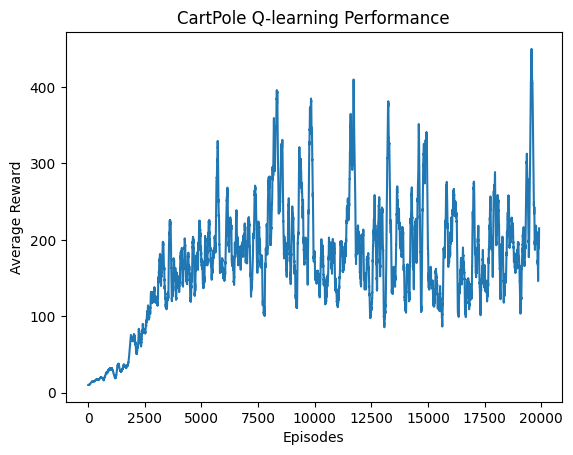

In [23]:
import matplotlib.pyplot as plt

def moving_average(data, window=100):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.plot(moving_average(rewards))
plt.title('CartPole Q-learning Performance')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.show()


In [18]:

obs, _ = env.reset()
done = False
while not done:
    state = discretize(obs)
    action = np.argmax(Q[state])
    obs, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    env.render()


KeyboardInterrupt: 

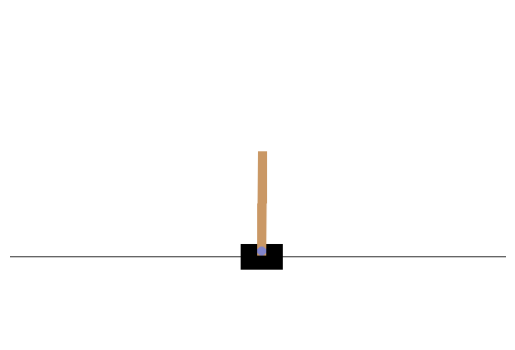

In [19]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

env = gym.make("CartPole-v1", render_mode="rgb_array")

obs, _ = env.reset()
done = False
frames = []

while not done:
    frame = env.render()  # get RGB frame
    frames.append(frame)
    state = discretize(obs)
    action = np.argmax(Q[state])
    obs, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

env.close()

# Play back the frames in Colab
for frame in frames:
    plt.imshow(frame)
    plt.axis('off')
    display(plt.gcf())
    clear_output(wait=True)
    time.sleep(0.03)  # ~30 FPS


In [24]:
import pickle

# Save the Q-table
with open("q_table.pkl", "wb") as f:
    pickle.dump(Q, f)


In [ ]:
""